In [64]:
# importing dataset 
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# reading in dataset 
environment = pd.read_csv('environmental_data.csv')
environment = environment.drop('Unnamed: 0', axis=1)

## Identifying Best `aspectname`

In [3]:
environment['aspectname'].value_counts()

Environmental Dimension                        18383
Environmental Reporting                        18366
Operational Eco-Efficiency                     18336
Climate Strategy                               17205
Environmental Policy & Management Systems      16496
Product Stewardship                             4746
Water Related Risks                             3337
Packaging                                       2236
Biodiversity                                    2236
Sustainable Agricultural Practices              1029
Genetically Modified Organisms                   986
Business Risks and Opportunities                 975
Transmission & Distribution                      700
Electricity Generation                           562
Building Materials                               420
Resource Conservation & Resource Efficiency      420
Fuel Efficiency                                  339
Food Loss & Waste                                228
Risk Detection                                

In [4]:
# filtering for environmental data
environment_sub = environment.loc[(environment['aspectname'] == 'Environmental Dimension')]

# copying dataset
environmentcopy = environment_sub.copy()

# Normalizing environment copy
environmentcopy['scorevalue'] = (environment['scorevalue'] - environment['scorevalue'].min()) / (environment['scorevalue'].max() - environment['scorevalue'].min()) 
environmentcopy['scorevalue'].value_counts()

0.00    2967
0.23     491
0.25     490
0.22     485
0.21     458
        ... 
0.92       8
0.95       7
0.96       5
0.97       3
0.98       3
Name: scorevalue, Length: 99, dtype: int64

`Environmental Dimension` has the lowest number of $0$ values making it the most optimal `aspectname` to evaluate.

## Correlation

In [5]:
# plotting heatmap 
environmentcopy.corrwith(environment["scorevalue"])

scorevalue       1.000000
scoreweight      0.185021
industryrank    -0.445278
companyid       -0.117075
gvkey           -0.163545
bm              -0.012526
gpm              0.014140
roe              0.033438
debt_assets      0.113498
curr_ratio      -0.156558
at_turn         -0.006598
year            -0.207155
mktcap_annual    0.280045
dtype: float64

<AxesSubplot:>

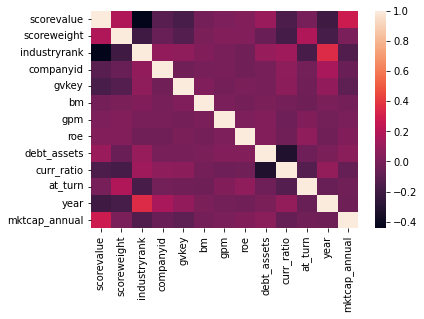

In [6]:
sns.heatmap(environmentcopy.corr())

## 

## Identifying Variable Transformations

In [7]:
# assigning good scores and bad scores
environmentcopy.loc[:,'scorevalue'] = environmentcopy.loc[:,'scorevalue'].apply(lambda x: 1 if x>environmentcopy.scorevalue.median() else 0)

In [32]:
# segmenting dataset into samples to get a training data and testing dataset
training_data = environmentcopy.sample(frac=0.8, random_state=20)
testing_data = environmentcopy.drop(training_data.index)

### `mktcap_annual`

In [9]:
environmentcopy['log_mktcap'] = np.log(environmentcopy['mktcap_annual'])
training_data['log_mktcap'] = np.log(training_data['mktcap_annual'])
testing_data['log_mktcap'] = np.log(testing_data['mktcap_annual'])

Optimization terminated successfully.
         Current function value: 0.635926
         Iterations 8


<AxesSubplot:xlabel='mktcap_annual', ylabel='scorevalue'>

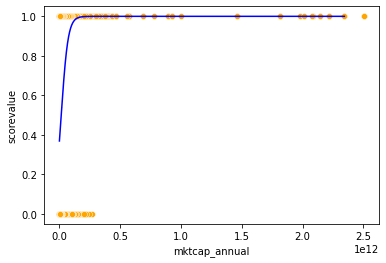

In [10]:
# developing logistic regression 
logit_model = sm.logit(formula = 'scorevalue~mktcap_annual', data = training_data).fit() 

# Visualizing model
sns.scatterplot(x = 'mktcap_annual', y = 'scorevalue', data = environmentcopy, color = 'orange') 
sns.lineplot(x = 'mktcap_annual', y= logit_model.predict(testing_data), data = environmentcopy, color = 'blue') 

Optimization terminated successfully.
         Current function value: 0.617318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615746
         Iterations 6
-9078.2747392161
-9055.159612602729


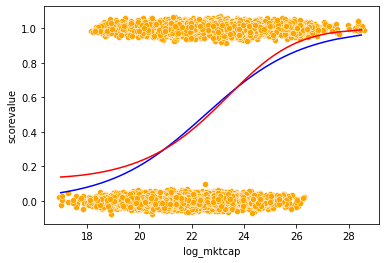

In [11]:
# Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(environmentcopy.log_mktcap,0), y = jitter(environmentcopy.scorevalue,0), data = environmentcopy, color = 'orange')

# plotting line for no transformation
logit_model = sm.logit(formula = 'scorevalue~log_mktcap', data = training_data).fit()
sns.lineplot(x = 'log_mktcap', y= logit_model.predict(testing_data), data = environmentcopy, color = 'blue') 

# yes transformation 
logit_model_transformed = sm.logit(formula = 'scorevalue~log_mktcap+I(log_mktcap**2)', data = training_data).fit()
sns.lineplot(x = 'log_mktcap', y= logit_model_transformed.predict(testing_data), data = environmentcopy, color = 'red') 
print(logit_model.llf) 
print(logit_model_transformed.llf)

With `mktcap_annual`, there are some large values that are meddling with the model's ability to classify between a _good_ score and a _bad_ score. To solve this, we took the log of `mktcap_annual`. The effectiveness of this variable transformation can be seen in the difference between the first and second visualization. The red line in the second visualization represents another variable transformation, but we see that this transformation is not very effective, so we will just use $log()$ transformation, which we know is very effective.

### `curr_ratio`

In [12]:
environmentcopy['log_currratio'] = np.log(environmentcopy['curr_ratio'])
training_data['log_currratio'] = np.log(training_data['curr_ratio'])
testing_data['log_currratio'] = np.log(testing_data['curr_ratio'])

Optimization terminated successfully.
         Current function value: 0.674812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669178
         Iterations 9
-8263.073389467307
-8194.081504340116


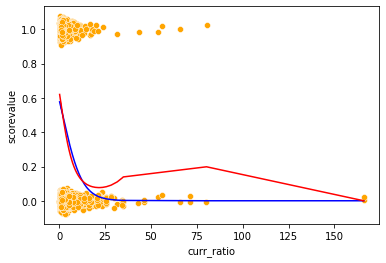

In [13]:
# plotting line for no transformation
sns.scatterplot(x = jitter(environmentcopy.curr_ratio,0), y = jitter(environmentcopy.scorevalue,0), data = environmentcopy, color = 'orange')
logit_model = sm.logit(formula = 'scorevalue~curr_ratio', data = training_data).fit()
sns.lineplot(x = 'curr_ratio', y= logit_model.predict(testing_data), data = environmentcopy, color = 'blue') 

# yes transformation 
logit_model_transformed = sm.logit(formula = 'scorevalue~curr_ratio+I(curr_ratio**2)+I(curr_ratio**3)', data = training_data).fit()
sns.lineplot(x = 'curr_ratio', y= logit_model_transformed.predict(testing_data), data = environmentcopy, color = 'red') 

print(logit_model.llf) 
print(logit_model_transformed.llf)

Optimization terminated successfully.
         Current function value: 0.672610
         Iterations 5
-8236.114815163657


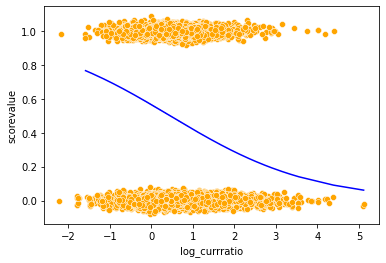

In [14]:
# Jittering points to better see the density of points in any given region of the plot
sns.scatterplot(x = jitter(environmentcopy.log_currratio,0), y = jitter(environmentcopy.scorevalue,0), data = environmentcopy, color = 'orange')

# plotting line for yes transformation
logit_model = sm.logit(formula = 'scorevalue~log_currratio', data = training_data).fit()
sns.lineplot(x = 'log_currratio', y= logit_model.predict(testing_data), data = environmentcopy, color = 'blue') 

print(logit_model.llf)

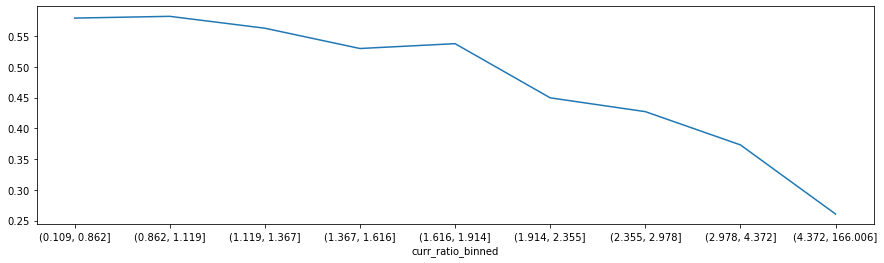

In [15]:
# binning curr_ratio
curr_ratio_binned = pd.qcut(environmentcopy['curr_ratio'],9,retbins = True)
environmentcopy['curr_ratio_binned'] = curr_ratio_binned[0]
data_grouped = environmentcopy.groupby('curr_ratio_binned')
ax = data_grouped['scorevalue'].mean().plot()
ax.figure.set_figwidth(15)

The two visualizations show that taking $log()$ of the `curr_ratio` variable is an effective transformation. The last linegraph effectively visualizes the relationship between a binned `curr_ratio` and the `scorevalue` — highlighting the negative correlation — but the binned `curr_ratio` variable has no effect on the model itself. 

### `csasectorname`

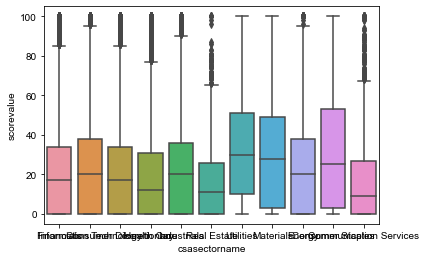

In [16]:
# building boxplot for sectors to see distribution 
sns.boxplot(data=environment, x="csasectorname", y="scorevalue")
sns.set(rc={'figure.figsize':(20,1-0)})

Intuitively, `csasectorname` which represents the industry an observation belongs in, would be a strong predictor for `scorevalue` since different industry sectors should interact with the environment in different capacities and manners.

### `debt_assets`

Optimization terminated successfully.
         Current function value: 0.685759
         Iterations 4
-10084.777643303485


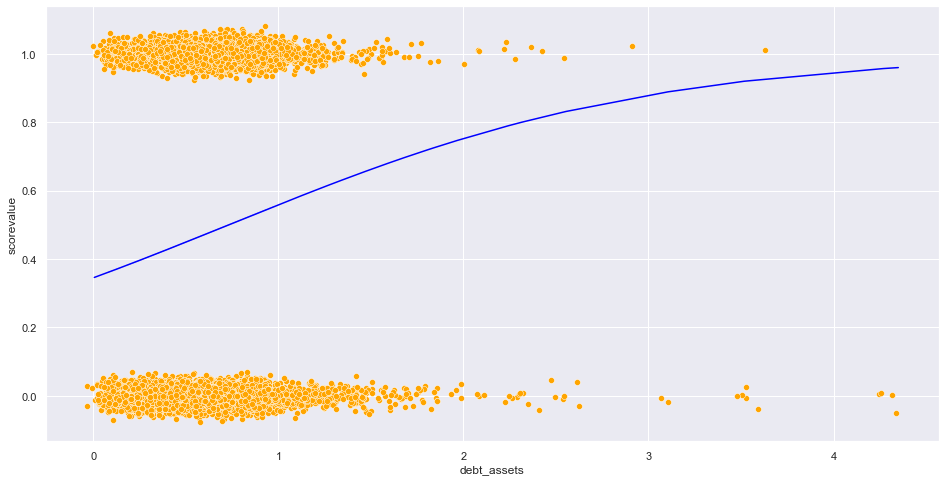

In [62]:
# plotting line for no transformation
sns.scatterplot(x = jitter(environmentcopy.debt_assets,0), y = jitter(environmentcopy.scorevalue,0), data = environmentcopy, color = 'orange')
logit_model = sm.logit(formula = 'scorevalue~debt_assets', data = training_data).fit()
sns.lineplot(x = 'debt_assets', y= logit_model.predict(testing_data), data = environmentcopy, color = 'blue') 
print(logit_model.llf)

In [50]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_debt_assets = pd.qcut(environmentcopy['debt_assets'],10,retbins=True)
    bins = binned_debt_assets[1]
    data['binned_debt_assets'] = pd.cut(data['debt_assets'],bins = bins)
    dum = pd.get_dummies(data.binned_debt_assets,drop_first = True)
    dum.columns = ['debt_assets'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

training_data = var_transform(training_data)
testing_data = var_transform(testing_data)

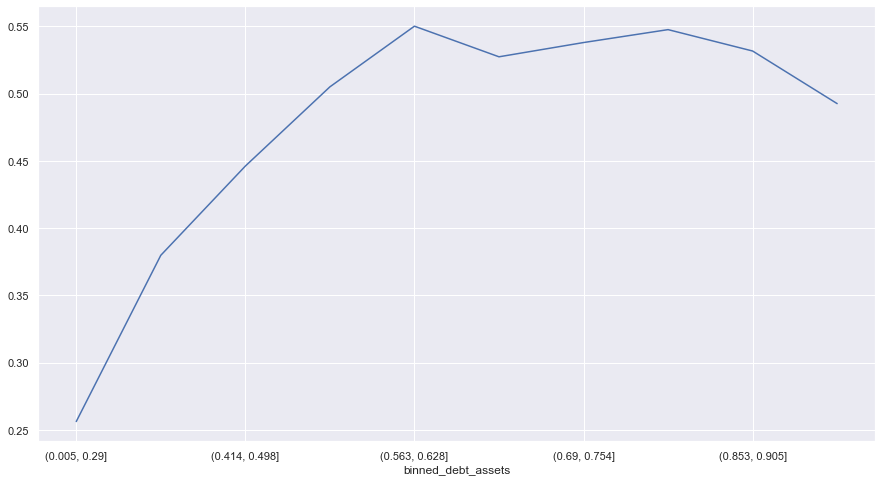

In [55]:
sns.set(rc={'figure.figsize':(16,8)})

# binning debt_assets
data_grouped = training_data.groupby('binned_debt_assets')
ax = data_grouped['scorevalue'].mean().plot()
ax.figure.set_figwidth(15)

Optimization terminated successfully.
         Current function value: 0.675617
         Iterations 5
-9935.61791768595


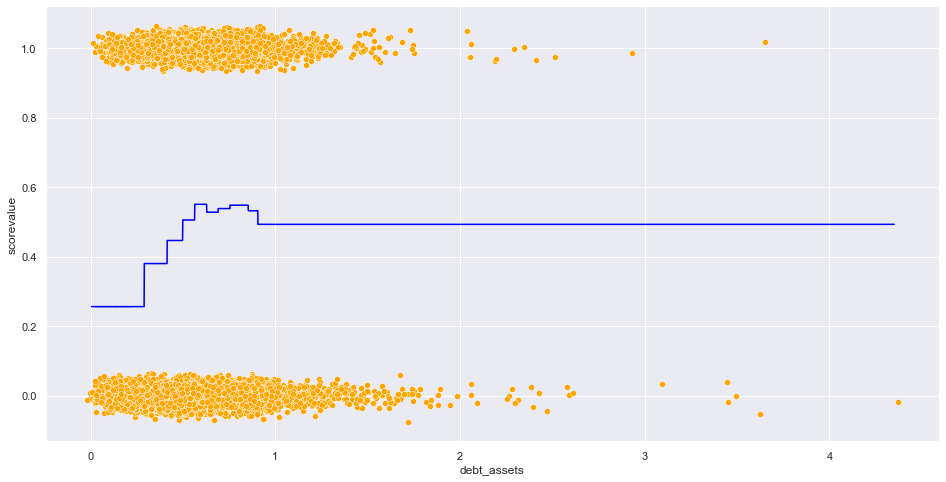

In [63]:
# Model with binned debt_assets
sns.scatterplot(x = jitter(training_data.debt_assets,0), y = jitter(training_data.scorevalue,0), data = training_data, color = 'orange')
logit_model = sm.logit(formula = 'scorevalue~' + '+'.join(['debt_assets'+str(x) for x in range(1,10)]), data = training_data).fit()
sns.lineplot(x = 'debt_assets', y= logit_model.predict(training_data), data = training_data, color = 'blue') 
print(logit_model.llf)

With the two visualizations, we see that binning the `debt_assets` variable is a very effective transformation that more clearly shows the trend or relationship between `debt_assets` and `scorevalue`.